In [9]:
import sys
sys.path.append("../")
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from axessettings import AxesSetting, linear_sim

# 変圧器

## (1) 抵抗測定

四端子法で1次(primary)、2次(secondary)の電圧、電流を測定

$r=R\frac{234.5+T}{234.5+t}$

In [10]:

R_p = 0.245
R_s = 0.0523
temp = 24.8

r_p = lambda T: R_p * (234.5 + T)/(234.5 + temp)
r_s = lambda T: R_s * (234.5 + T)/(234.5 + temp)

## (2) 無負荷試験・短絡試験

### 無負荷試験

**1次側：定格電圧**

電流$\dot{I}$、電圧$\dot{V}$、電力の実効値$\dot{P}$、位相差$\theta$($V$基準)が与えられている。

アドミタンス$Y_0=G_0+jB_0=|Y_0|e^{j\theta}$。

$I = Y_0V = |Y_0|e^{j\theta}V$

$\therefore |Y_0| = \sqrt{G_0^2 + B_0^2} = \frac{\dot{I}}{\dot{V}}$

$\dot{P} = \text{Re}(IV)=\dot{I}\dot{V}\cos{\theta}$

$\text{Re}\,Y_0 = G_0 = \frac{\dot{P}}{\dot{V}^2}$

$B_0$は$\omega$依存？

In [11]:
# 解放の測定
I_open = 0.587
V_open = 200.00
P_open = 26.1
phase_open = 2*np.pi*4.9/20 #radian

#
print(f"P (measured) = {P_open}")
print(f"P = IVcosΘ = {I_open*V_open*np.cos(phase_open): .2f}")

G_0 = P_open / V_open**2
B_0 = -np.sqrt((I_open/V_open)**2 - G_0**2)
Y_0 = G_0 + 1j * B_0

print(f"G_0 = {G_0 : .2e}")
print(f"B_0 = {B_0 : .2e}")
print(f"Y_0 = {Y_0 : .2e}")

P (measured) = 26.1
P = IVcosΘ =  3.69
G_0 =  6.53e-04
B_0 = -2.86e-03
Y_0 =  6.53e-04-2.86e-03j


### 短絡試験

**2次側：定格電流** (小電圧・電流)

電流$\dot{I}$、電圧$\dot{V}$、電力の実効値$\dot{P}$、位相差$\theta$($I$基準)が与えられている。

インピーダンス$Z_1=R_1+jX_1=|Z_1|e^{j\theta}$。

$V = Z_1I = |Z_1|e^{j\theta}I$

$\therefore |Z_1| = \sqrt{R_1^2 + X_1^2} = \frac{\dot{V}}{\dot{I}}$

$\dot{P} = \text{Re}(IV)=\dot{I}\dot{V}\cos{\theta}$

$\text{Re}\,Z_1 = R_1 = \frac{\dot{P}}{\dot{I}^2}$

$B_0$は$\omega$依存？

In [12]:
# 短絡の測定
I_short = 10.000
V_short = 6.49
P_short = 54.9
phase_short = 2*np.pi*1.8/20

#
print(f"P (measured) = {P_short}")
print(f"P = IVcosΘ = {I_short*V_short*np.cos(phase_short): .2f}")

R_1 = P_short/I_short**2
X_1 = np.sqrt((V_short/I_short)**2 - R_1**2)
Z_1 = R_1 + 1j * X_1

print(f"R_1 = {R_1 : .2f}")
print(f"R_theory @75℃ = {r_p(75) + 0.5**2 * r_s(75): .2f}")
print(f"X_1 = {X_1 : .2f}")
print(f"Z_1 = {Z_1 : .2f}")

P (measured) = 54.9
P = IVcosΘ =  54.80
R_1 =  0.55
R_theory @75℃ =  0.31
X_1 =  0.35
Z_1 =  0.55+0.35j


## (3) 負荷試験

In [13]:
df_trans = pd.read_csv("data_trans_real.csv")
df_trans

efficiency = lambda P0, pf, c, Wi, Wc: P0*pf*c / (P0*pf*c + Wi + Wc * c**2) * 100

電圧変動率
$\epsilon = \frac{V_{20} - V_{2n}}{V_{2n}} \times100$

In [14]:
e = (df_trans.iloc[0]["V2"] - df_trans.iloc[-1]["V2"]) / df_trans.iloc[-1]["V2"] * 100
print(f"Change rate = {e:.2f}%")

Change rate = 3.10%


**1次側：定格電圧**

$\eta_C = \frac{\text{出力}}{\text{出力} +\text{損失}} \times 100 = \frac{P_0\times pf\times c}{P_0\times pf\times c + W_i + W_c\times c^2}\times 100$

Where $P_0$: 定格出力、$pf$: 負荷力率、$c: \frac{\text{負荷電流}}{\text{定格電流}}$、$W_i$: 定格電圧における鉄損、$W_c$: 定格電流における銅損


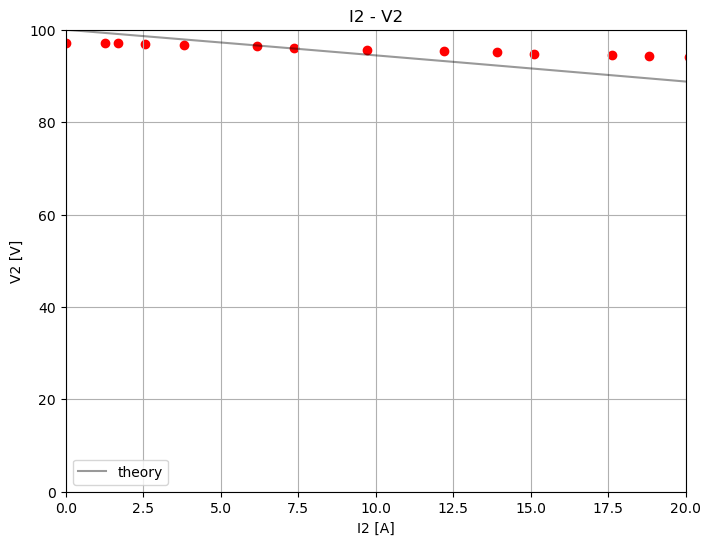

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
axessetting = AxesSetting(legend=True, xlabel="I2 [A]", ylabel="V2 [V]", grid="both", xlim=(0, 20), title="I2 - V2", ylim=(0, 100))
Wi = G_0 * 200 ** 2
Wc = P_short
axessetting.plot_func(ax, lambda I2: (-R_1*I2*2 + np.sqrt(200**2 - X_1**2 * (I2*2)**2)) / 2, label="theory", c="black", alpha=0.4)
ax.scatter(df_trans["I2"], df_trans["V2"], c="red")
axessetting.apply_axes(ax)

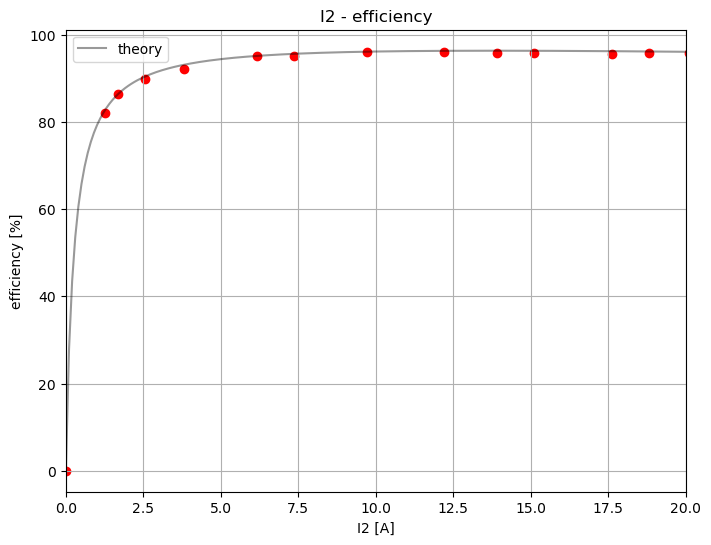

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
axessetting = AxesSetting(legend=True, xlabel="I2 [A]", ylabel="efficiency [%]", grid="both", xlim=(0, 20), title="I2 - efficiency")
Wi = G_0 * 200 ** 2
Wc = P_short
axessetting.plot_func(ax, lambda I2: efficiency(2000, 1, I2/20, Wi, Wc), label="theory", c="black", alpha=0.4)
ax.scatter(df_trans["I2"], df_trans["P2"]/df_trans["P1"]*100, c="red")
axessetting.apply_axes(ax)